In [32]:
# Steps to preprocess data

# remove all features which underwent embedding
# remove features (admitdate)
# OHE for admission_type, admission_location, insurance, marital_status
# choose either readmitted_30 or readmitted_60 or days_to_next_admission
# currently, if next admission is not present, then days_to_next_admission is not an integer -- need to convert to -1

In [33]:
# Check if CUDA is installed
import torch
print(torch.cuda.is_available())

True


In [34]:
# Imports
import pickle
import torch
from transformers import BertTokenizer, BertModel

In [35]:
# Load data
X_filePath = '../../../data/processedData/X_RNN.pkl'
with open(X_filePath, 'rb') as f:
    data = pickle.load(f)

In [36]:
for subject_id, nested_dict in data.items():
    for hadm_id, record in nested_dict.items():
        record.pop('diagnoses', None)
        record.pop('drugs', None)
        record.pop('procedures', None)
        record.pop('days_to_next_admission', None)
        record.pop('readmitted_60', None)
        record.pop('admitdate', None)



In [37]:
def explore_nested_dict(data, top_key):
    if top_key in data:
        nested_dict = data[top_key]
        print(f"Top-level Key: {top_key}")
        print(f"Keys in nested dictionary: {nested_dict.keys()}")
        
        # Inspect one of the nested keys in detail
        for nested_key in nested_dict:
            print(f"\nNested Key: {nested_key}")
            print(f"Type of value: {type(nested_dict[nested_key])}")
            print(f"Value sample: {nested_dict[nested_key]}")
    else:
        print(f"Key {top_key} not found in the data.")


top_key_to_inspect = 10000032

explore_nested_dict(data, top_key_to_inspect)

Top-level Key: 10000032
Keys in nested dictionary: dict_keys([22595853, 22841357, 29079034])

Nested Key: 22595853
Type of value: <class 'dict'>
Value sample: {'timespent': 18, 'admission_type': 'URGENT', 'admission_location': 'TRANSFER FROM HOSPITAL', 'insurance': 'Other', 'marital_status': 'WIDOWED', 'hospital_expire_flag': 0, 'readmitted_30': 0, 'combined_embedding': array([ 7.06353039e-02,  1.66799352e-01, -2.93788612e-01,  2.35119641e-01,
       -3.58550340e-01,  1.39132544e-01,  5.30576766e-01,  3.92042994e-01,
        5.16894698e-01, -5.82762897e-01, -3.87033671e-01,  4.64646667e-01,
       -1.72051430e-01, -2.54900634e-01, -2.81801522e-01,  1.05978683e-01,
       -1.37993753e-01,  2.99448967e-01,  2.27836743e-01, -4.71671760e-01,
       -1.65306076e-01,  1.79964855e-01, -2.02964187e-01, -3.18241209e-01,
       -1.21349744e-01,  9.52861235e-02,  5.16720951e-01,  5.11681795e-01,
       -2.99426087e-04,  1.92941874e-01,  1.77122504e-01,  5.75323701e-01,
        5.03390208e-02, -1.

In [38]:
print(data.keys().__len__())

43814


In [39]:
from collections import defaultdict
import numpy as np

# Step 1: Find all unique categories for each field
unique_categories = defaultdict(set)
fields_to_encode = ["admission_type", "admission_location", "insurance", "marital_status"]

for subject_id, nested_dict in data.items():
    for hadm_id, record in nested_dict.items():
        for field in fields_to_encode:
            if field in record:
                value = record[field]
                if value is None:
                    value = "UNKNOWN"  # Handle null values
                value = str(value)  # Ensure all values are strings
                unique_categories[field].add(value)

# Step 2: Create a mapping from category to index
category_to_index = {
    field: {category: i for i, category in enumerate(sorted(categories))}
    for field, categories in unique_categories.items()
}

# Step 3: Replace string values with one-hot encoded vectors
for subject_id, nested_dict in data.items():
    for hadm_id, record in nested_dict.items():
        for field in fields_to_encode:
            if field in record:
                value = record[field]
                if value is None:
                    value = "UNKNOWN"  # Handle null values
                value = str(value)  # Ensure value is a string
                # Get the index for the category
                index = category_to_index[field][value]
                # Create a one-hot encoded vector
                ohe_vector = np.zeros(len(category_to_index[field]), dtype=int)
                ohe_vector[index] = 1
                # Replace the original string value with the one-hot vector
                record[field] = ohe_vector

# Confirmation message
print("One-hot encoding completed successfully.")


One-hot encoding completed successfully.


In [40]:
explore_nested_dict(data, top_key_to_inspect)

Top-level Key: 10000032
Keys in nested dictionary: dict_keys([22595853, 22841357, 29079034])

Nested Key: 22595853
Type of value: <class 'dict'>
Value sample: {'timespent': 18, 'admission_type': array([0, 0, 0, 0, 0, 0, 0, 0, 1]), 'admission_location': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]), 'insurance': array([0, 0, 1]), 'marital_status': array([0, 0, 0, 1, 0]), 'hospital_expire_flag': 0, 'readmitted_30': 0, 'combined_embedding': array([ 7.06353039e-02,  1.66799352e-01, -2.93788612e-01,  2.35119641e-01,
       -3.58550340e-01,  1.39132544e-01,  5.30576766e-01,  3.92042994e-01,
        5.16894698e-01, -5.82762897e-01, -3.87033671e-01,  4.64646667e-01,
       -1.72051430e-01, -2.54900634e-01, -2.81801522e-01,  1.05978683e-01,
       -1.37993753e-01,  2.99448967e-01,  2.27836743e-01, -4.71671760e-01,
       -1.65306076e-01,  1.79964855e-01, -2.02964187e-01, -3.18241209e-01,
       -1.21349744e-01,  9.52861235e-02,  5.16720951e-01,  5.11681795e-01,
       -2.99426087e-04,  1.92941874e-0

In [41]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [42]:
# Updated Data Preparation Function
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def prepare_data_for_sequential_rnn(data_dict, 
                                    embedding_size=768, 
                                    procedures_embedding_size=100, 
                                    max_admissions=100):
    """
    Prepare data for an RNN model with ClinicalBERT embeddings and sequence truncation.
    """
    sequences = []  # Holds sequences of admissions for each patient
    labels = []     # Holds readmitted_30 labels for each admission

    for subject_id, admissions in data_dict.items():
        patient_sequence = []
        patient_labels = []
        for hadm_id, features in admissions.items():
            combined_embedding = (
                features.get('combined_embedding', np.zeros(embedding_size))
                if isinstance(features.get('combined_embedding'), np.ndarray) and 
                features['combined_embedding'].shape[0] == embedding_size
                else np.zeros(embedding_size)
            )
            procedures_embedding = (
                features.get('procedures_embedding', np.zeros(procedures_embedding_size))
                if isinstance(features.get('procedures_embedding'), np.ndarray) and 
                features['procedures_embedding'].shape[0] == procedures_embedding_size
                else np.zeros(procedures_embedding_size)
            )
            feature_vector = np.concatenate([
                [features['timespent']],
                features['admission_type'],
                features['admission_location'],
                features['insurance'],
                features['marital_status'],
                [features['hospital_expire_flag']],
                combined_embedding,
                procedures_embedding
            ])
            patient_sequence.append(feature_vector)
            patient_labels.append(features['readmitted_30'])

        if len(patient_sequence) > max_admissions:
            patient_sequence = patient_sequence[:max_admissions]
            patient_labels = patient_labels[:max_admissions]

        sequences.append(patient_sequence)
        labels.append(patient_labels)

    feature_size = len(sequences[0][0]) if sequences and sequences[0] else 0
    padded_sequences = pad_sequences(
        sequences,
        maxlen=max_admissions,
        padding='post',
        dtype='float16',
        value=-1  # Set padding value to -1
    )
    padded_labels = pad_sequences(
        labels,
        maxlen=max_admissions,
        padding='post',
        value=-1  # Set padding value to -1
    )

    return padded_sequences, padded_labels


In [43]:
max_admissions = 100  # Limit to 100 admissions per patient
embedding_size = 768  # ClinicalBERT embedding size
procedures_embedding_size = 100  # Procedures embedding size

# Prepare the data
sequences, labels = prepare_data_for_sequential_rnn(data, embedding_size, procedures_embedding_size, max_admissions)

print("Sequences shape:", sequences.shape)  # (patients, max_admissions, features_per_admission)
print("Labels shape:", labels.shape)        # (patients, max_admissions)

Sequences shape: (43814, 100, 898)
Labels shape: (43814, 100)


In [44]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [45]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (35051, 100, 898)
y_train shape: (35051, 100, 1)


In [46]:
# Check unique values in y_train
unique_labels = np.unique(y_train)
print("Unique values in y_train:", unique_labels)

# Verify if all labels are binary
if set(unique_labels).issubset({0, 1}):
    print("All labels are binary (0 or 1).")
else:
    print("Some labels are not binary. Check the data.")


Unique values in y_train: [-1  0  1]
Some labels are not binary. Check the data.


In [47]:
import tensorflow as tf

# Check if TensorFlow is using the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

# Test computation on GPU
with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0, 3.0]])
    b = tf.constant([[4.0], [5.0], [6.0]])
    c = tf.matmul(a, b)
    print(c)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPU.")
    except RuntimeError as e:
        print(e)


Num GPUs Available:  0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _MklMatMul in device /job:localhost/replica:0/task:0/device:CPU:0
tf.Tensor([[32.]], shape=(1, 1), dtype=float32)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, TimeDistributed

# Convert the data to float16 for consistency
X_train = X_train.astype('float16')
y_train = y_train.astype('float16')


# Custom Loss Function to Ignore -1 in Labels
def custom_loss(y_true, y_pred):
    mask = tf.not_equal(y_true, -1)  # Create mask for valid labels
    mask = tf.cast(mask, tf.float32)  # Cast mask to float32 for broadcasting
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    loss = loss * tf.squeeze(mask, axis=-1)  # Apply mask, squeezing the last dimension of mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)  # Normalize by the sum of valid mask values




# Build RNN Model
def build_rnn_model(input_shape):
    model = Sequential([
        Masking(mask_value=-1.0, input_shape=input_shape, dtype='float16'),  # Mask -1 values
        LSTM(128, return_sequences=True, dtype='float16'),
        LSTM(64, return_sequences=True, dtype='float16'),
        TimeDistributed(Dense(1, activation='sigmoid', dtype='float16'))
    ])
    model.compile(
        loss=custom_loss,  # Use custom loss function
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    return model

# Build and Train the Model
input_shape = X_train.shape[1:]
model = build_rnn_model(input_shape)

# Debug: Check data shapes and types
print(f"X_train dtype: {X_train.dtype}, y_train dtype: {y_train.dtype}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")



Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0


c:\Users\James\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/d

In [50]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=8,
    epochs=5
)

# Save the model
model.save("rnn_model_PAD-1.h5")

MemoryError: Unable to allocate 11.7 GiB for an array with shape (35051, 100, 898) and data type float32

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Pr

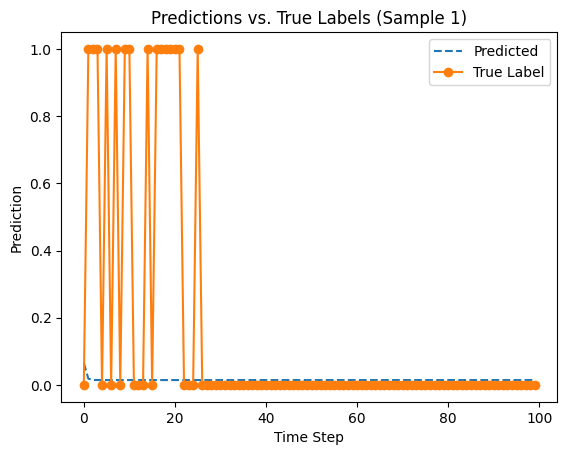

In [27]:
# Load the model (if needed)
# model = tf.keras.models.load_model("rnn_model_float16.h5")

# Assuming X_test and y_test are your test datasets
# Convert to float16 for consistency
X_test = X_test.astype('float16')
y_test = y_test.astype('float16')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=8, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Make predictions
predictions = model.predict(X_test, batch_size=8)

# Display predictions vs. true labels for a few samples
import numpy as np

# Convert predictions to binary (0 or 1) for comparison
binary_predictions = (predictions > 0.5).astype(int)

# Number of samples to display
num_samples = 10

print("\nSample Predictions vs True Labels:")
for i in range(num_samples):
    print(f"Sample {i + 1}:")
    print(f"Predicted: {binary_predictions[i].flatten()}")
    print(f"True Label: {y_test[i].flatten()}")
    print()

# Plot predictions for visualization (optional)
import matplotlib.pyplot as plt

# Select a sample for visualization
sample_index = 0
plt.plot(predictions[sample_index], label='Predicted', linestyle='--')
plt.plot(y_test[sample_index], label='True Label', marker='o')
plt.title(f"Predictions vs. True Labels (Sample {sample_index + 1})")
plt.xlabel("Time Step")
plt.ylabel("Prediction")
plt.legend()
plt.show()


In [28]:
# Assuming X_test and y_test are already prepared test datasets
# Ensure the test data is in float16 format for consistency
X_test = X_test.astype('float16')
y_test = y_test.astype('float16')

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=8, verbose=1)

# Print evaluation results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions for the test set
predictions = model.predict(X_test, batch_size=8)

# Convert predictions to binary format (threshold = 0.5)
binary_predictions = (predictions > 0.5).astype(int)

# Display metrics for comparison
from sklearn.metrics import classification_report

# Flatten arrays for metric calculation
y_test_flat = y_test.flatten()
binary_predictions_flat = binary_predictions.flatten()

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test_flat, binary_predictions_flat, target_names=["Class 0", "Class 1"]))

# Example: Display the first few samples
num_samples = 5
print("\nSample Predictions vs True Labels:")
for i in range(num_samples):
    print(f"Sample {i + 1}:")
    print(f"Predicted: {binary_predictions[i].flatten()}")
    print(f"True Label: {y_test[i].flatten()}")
    print()


Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Pr